In [1]:
import pandas as pd
import numpy as np
import rpy2 as rpy2
import scipy.stats as stats
import rpy2.robjects as ro

from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.rinterface_lib.embedded import RRuntimeError


from Helpers.FunctHelpers import *
from Helpers.PlotHelpers import *

In [2]:
# Download data

tickers = pd.read_excel('Data/SandP500list.xlsx')
tickers = tickers[tickers['sector'] == 'Financials']
names = tickers['symbol'].tolist()

start_date = pd.to_datetime('2022-01-01') # train 12 months
end_date = pd.to_datetime('2023-07-01') # test 6 months

data = download_data(names, start_date, end_date)

[*********************100%***********************]  65 of 65 completed


6 Failed downloads:
['WLTW', 'PBCT', 'RE', 'FRC', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SIVB']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [3]:
# Split into train and test data

train_start = pd.to_datetime('2022-01-01')
train_end = pd.to_datetime('2022-12-31')
test_start = pd.to_datetime('2023-01-01')
test_end = pd.to_datetime('2023-07-01')

train_data, test_data = train_test_split(data, train_start, train_end, test_start, test_end)
print(train_data.shape, test_data.shape)

(251, 59) (124, 59)


In [4]:
# Calculate SSD and select 20 pairs with lowest SSD

train_data_cum = train_data.pct_change().cumsum().dropna(axis=0)

ssd_train = find_ssd(train_data_cum)
pairs = select_lowest_ssd(ssd_train, train_data_cum)

print(f'Choosen pairs: {len(pairs)} from {round(len(data.columns) * (len(data.columns) - 1) / 2)} posssible pairs')

Choosen pairs: 20 from 1711 posssible pairs


In [5]:
print(pairs)

[('MCO', 'SPGI'), ('NTRS', 'USB'), ('FITB', 'KEY'), ('AFL', 'MET'), ('AIG', 'HIG'), ('CMA', 'ZION'), ('CFG', 'KEY'), ('PNC', 'TFC'), ('KEY', 'TFC'), ('C', 'PNC'), ('TFC', 'USB'), ('CFG', 'FITB'), ('GL', 'MET'), ('ALL', 'TRV'), ('MET', 'TRV'), ('AON', 'MMC'), ('FITB', 'TFC'), ('CB', 'MET'), ('BAC', 'BK'), ('FITB', 'USB')]


In [6]:
# Find and fit the best fitting distributions to the returns of the selected pairs

def fit_distributions(stock_returns):
    """Fit distributions to the stock returns and select the best fit based on AIC and BIC.

    Args:
        stock_returns (pd.Series): Stock returns.


    Returns:
        str: Name of the best fit distribution.
        dict: Parameters of the best fit distribution.
    """
    # List of distributions to check
    distributions = {
        'extreme_value': stats.genextreme,
        'generalized_extreme_value': stats.gumbel_r,
        'logistic': stats.logistic,
        'normal': stats.norm
    }
    
    results = {}
    for dist_name, dist in distributions.items():
        # Fit distribution to the data
        params = dist.fit(stock_returns)
        # Calculate the negative log likelihood
        nll = -np.sum(dist.logpdf(stock_returns, *params))
        # Calculate AIC and BIC
        k = len(params)
        n = len(stock_returns)
        aic = 2 * k + 2 * nll
        bic = k * np.log(n) + 2 * nll
        results[dist_name] = {'params': params, 'aic': aic, 'bic': bic}
    
    # Select the distribution with the lowest AIC and BIC
    best_fit = sorted(results.items(), key=lambda x: (x[1]['aic'], x[1]['bic']))[0]
    return best_fit[0], results[best_fit[0]]['params']


def fit_best_distribution_for_pairs(train_data, pairs):
    """Fit distributions to the returns of the selected pairs.

    Args:
        train_data (pd.DataFrame): Train data.
        pairs (list): List of pairs.

    Returns:
        dict: Best fit distributions for the pairs.
    """
    best_fit_distributions = {}
    for pair in pairs:
        best_fit_distributions[pair] = {}
        for stock in pair:
            stock_returns = train_data[stock].pct_change().dropna()
            best_dist, best_params = fit_distributions(stock_returns)
            best_fit_distributions[pair][stock] = {'distribution': best_dist, 'params': best_params}
    return best_fit_distributions

best_fits = fit_best_distribution_for_pairs(train_data, pairs)
print(best_fits)

{('MCO', 'SPGI'): {'MCO': {'distribution': 'logistic', 'params': (-0.0009517837915584541, 0.012062501787763765)}, 'SPGI': {'distribution': 'logistic', 'params': (-0.0014735901932198402, 0.010634401892772783)}}, ('NTRS', 'USB'): {'NTRS': {'distribution': 'logistic', 'params': (-0.0005312096899330696, 0.011861902559366927)}, 'USB': {'distribution': 'logistic', 'params': (-0.0004661552213291428, 0.010007879303046554)}}, ('FITB', 'KEY'): {'FITB': {'distribution': 'logistic', 'params': (-0.0013122914523006398, 0.012578387144784304)}, 'KEY': {'distribution': 'logistic', 'params': (-0.0014307870843776962, 0.012037105012222462)}}, ('AFL', 'MET'): {'AFL': {'distribution': 'logistic', 'params': (0.0009745434466441849, 0.008316224793863783)}, 'MET': {'distribution': 'logistic', 'params': (0.0005990157818284459, 0.008863354420453858)}}, ('AIG', 'HIG'): {'AIG': {'distribution': 'logistic', 'params': (0.0008513440866925682, 0.011422372927985116)}, 'HIG': {'distribution': 'normal', 'params': (0.00056

In [7]:
# Transform the stock returns to uniform margins using the best fit distributions

def transform_to_uniform(train_data, best_fit_distributions):
    """Transform the stock returns to uniform margins using the best fit distributions.

    Args:
        train_data (pd.DataFrame): Train data.
        best_fit_distributions (dict): Best fit distributions for the pairs.

    Raises:
        ValueError: If the distribution is not supported.

    Returns:
        dict: Uniform margins.
    """
    uniform_margins = {}
    for pair, fits in best_fit_distributions.items():
        uniform_margins[pair] = {}
        for stock, fit in fits.items():
            dist_name = fit['distribution']
            params = fit['params']
            
            # Get the appropriate distribution from scipy.stats
            if dist_name == 'extreme_value':
                dist = stats.genextreme
            elif dist_name == 'generalized_extreme_value':
                dist = stats.gumbel_r
            elif dist_name == 'logistic':
                dist = stats.logistic
            elif dist_name == 'normal':
                dist = stats.norm
            else:
                raise ValueError("Distribution not supported")
            
            # Calculate the CDF values for the stock returns, which will be uniform
            stock_returns = train_data[stock].pct_change().dropna()
            cdf_values = dist.cdf(stock_returns, *params)
            uniform_margins[pair][stock] = cdf_values

    return uniform_margins

uniform_data = transform_to_uniform(train_data, best_fits)
print(uniform_data)


{('MCO', 'SPGI'): {'MCO': array([0.65883751, 0.13011924, 0.38808355, 0.39834319, 0.09253964,
       0.81302459, 0.77113346, 0.09857374, 0.12047114, 0.11285305,
       0.64813657, 0.43871859, 0.32356006, 0.64903747, 0.01086878,
       0.48848587, 0.60620982, 0.94117666, 0.84260715, 0.57356843,
       0.69809898, 0.17958326, 0.84117394, 0.08321506, 0.62192142,
       0.78863905, 0.85075338, 0.01555961, 0.10702088, 0.84635834,
       0.56954459, 0.14225724, 0.54779819, 0.4857784 , 0.27118487,
       0.74489422, 0.62634867, 0.41367376, 0.54023666, 0.73400285,
       0.45058836, 0.57902008, 0.05964125, 0.47430496, 0.92668922,
       0.09043613, 0.0803807 , 0.313995  , 0.82701746, 0.90735824,
       0.87147615, 0.92416291, 0.26359887, 0.75707556, 0.24261186,
       0.71871852, 0.58249705, 0.80150992, 0.73729695, 0.44067602,
       0.46404142, 0.68918843, 0.64067206, 0.5245483 , 0.43834027,
       0.65262382, 0.47809511, 0.12632881, 0.38366901, 0.61261103,
       0.22653069, 0.50899695, 0.805

In [9]:
# Fit the best fitting copulas based on BIC to the transformed data

def fit_best_copulas_to_pairs(uniform_data):
    """Fit the best fitting copulas based on BIC to the transformed data.

    Args:
        uniform_data (dict): Uniform margins.

    Returns:
        dict: Results of fitting copulas to the pairs.
    """

    numpy2ri.activate()

    try:
        copula = importr('copula')
        print("Copula package loaded successfully.")
    except RRuntimeError:
        print("Installing copula package...")
        ro.r('install.packages("copula", repos="http://cran.r-project.org")')
        copula = importr('copula')


    results = {}
    for pair, data in uniform_data.items():
        u1 = ro.FloatVector(data[pair[0]])
        u2 = ro.FloatVector(data[pair[1]])
        data_matrix = ro.r['cbind'](u1, u2)

        copulas = {
            'Clayton': copula.claytonCopula(),
            'Gumbel': copula.gumbelCopula(),
            'StudentT': copula.tCopula(dim=2)
        }

        copula_fits = {}
        for name, copula_model in copulas.items():
            try:
                fit = copula.fitCopula(copula_model, data_matrix, method="ml")
                logLik = ro.r['logLik'](fit)
                aic = ro.r['AIC'](fit)
                bic = ro.r['BIC'](fit)
                copula_fits[name] = {
                    'logLik': logLik[0],
                    'AIC': aic[0],
                    'BIC': bic[0],
                    'model': fit  # Store the fitted model for later use
                }
            except RRuntimeError as e:
                print(f"Error fitting {name} copula for pair {pair}: {e}")

        # Select the best copula based on BIC
        best_copula = min(copula_fits, key=lambda x: copula_fits[x]['BIC'])
        results[pair] = {
            'Best Copula': best_copula,
            'Fits': copula_fits[best_copula],
            'Fitted Model': copula_fits[best_copula]['model']  # Include the fitted model
        }
    
    return results


copula_results = fit_best_copulas_to_pairs(uniform_data)
print(copula_results)

Copula package loaded successfully.
{('MCO', 'SPGI'): {'Best Copula': 'StudentT', 'Fits': {'logLik': 203.9363101903669, 'AIC': -403.8726203807338, 'BIC': -396.8296985450093, 'model': <rpy2.robjects.methods.RS4 object at 0x12c331050> [25]
R classes: ('fitCopula',)}, 'Fitted Model': <rpy2.robjects.methods.RS4 object at 0x12c331050> [25]
R classes: ('fitCopula',)}, ('NTRS', 'USB'): {'Best Copula': 'StudentT', 'Fits': {'logLik': 119.91555139895581, 'AIC': -235.83110279791163, 'BIC': -228.78818096218714, 'model': <rpy2.robjects.methods.RS4 object at 0x12c3302d0> [25]
R classes: ('fitCopula',)}, 'Fitted Model': <rpy2.robjects.methods.RS4 object at 0x12c3302d0> [25]
R classes: ('fitCopula',)}, ('FITB', 'KEY'): {'Best Copula': 'StudentT', 'Fits': {'logLik': 266.72748235554843, 'AIC': -529.4549647110969, 'BIC': -522.4120428753723, 'model': <rpy2.robjects.methods.RS4 object at 0x12c337690> [25]
R classes: ('fitCopula',)}, 'Fitted Model': <rpy2.robjects.methods.RS4 object at 0x12c337690> [25]
R c

In [10]:
# Calculate trading signals based on copula-based mispricing


def calculate_returns(data):
    """Calculate returns from the data.

    Args:
        data (pd.DataFrame): Data.

    Returns:
        pd.DataFrame: Returns.
    """
    return data.pct_change().fillna(0)

def get_trading_signals_copula(test_data, pairs, copula_results, diff_threshold=0.025, logLik_threshold=50):
    """Generate trading signals based on copula-based mispricing.

    Args:
        test_data (pd.DataFrame): Test data.
        pairs (list): List of pairs.
        copula_results (dict): Results of fitting copulas to the pairs.
        diff_threshold (float): Threshold for the mean difference.
        logLik_threshold (float): Threshold for the copula log likelihood.

    Returns:
        pd.DataFrame: Trading signals.
    """
    normalized_test_data = test_data / test_data.iloc[0]
    all_pair_signals = pd.DataFrame(index=normalized_test_data.index)

    for pair in pairs:
        if pair in copula_results:
            stock1, stock2 = pair
            data = copula_results[pair]
            logLik = data['Fits']['logLik']

            if stock1 in normalized_test_data.columns and stock2 in normalized_test_data.columns:
                pair_signals = pd.DataFrame({
                    stock1: normalized_test_data[stock1],
                    stock2: normalized_test_data[stock2]
                })

                returns = calculate_returns(pair_signals)
                mean_diff = returns[stock1] - returns[stock2]

                # Generate trading signals based on copula log likelihood and mean difference
                signal1 = np.where((mean_diff.abs() > diff_threshold) & (logLik > logLik_threshold),
                                   np.where(mean_diff > 0, 1, -1), 0)
                signal2 = -signal1

                # Calculate positions
                positions1 = np.zeros_like(signal1)
                positions2 = np.zeros_like(signal2)
                positions1[1:] = np.diff(signal1)
                positions2[1:] = np.diff(signal2)

                # Normalize positions to 1 whenever a change occurs
                positions1 = np.where(positions1 != 0, np.sign(positions1), 0)
                positions2 = np.where(positions2 != 0, np.sign(positions2), 0)

                all_pair_signals[f'{stock1}_{stock2}_signal1'] = signal1
                all_pair_signals[f'{stock1}_{stock2}_positions1'] = positions1
                all_pair_signals[f'{stock1}_{stock2}_signal2'] = signal2
                all_pair_signals[f'{stock1}_{stock2}_positions2'] = positions2
            else:
                print(f"Warning: Columns {stock1} or {stock2} not found in test data.")
        else:
            print(f"Warning: No copula data found for pair {pair}.")

    return all_pair_signals


signals = get_trading_signals_copula(test_data, pairs, copula_results) #! Adjust the threshold values later
print(signals)

            MCO_SPGI_signal1  MCO_SPGI_positions1  MCO_SPGI_signal2  \
Date                                                                  
2023-01-03                 0                    0                 0   
2023-01-04                 0                    0                 0   
2023-01-05                 0                    0                 0   
2023-01-06                 0                    0                 0   
2023-01-09                 0                    0                 0   
...                      ...                  ...               ...   
2023-06-26                 0                    0                 0   
2023-06-27                 0                    0                 0   
2023-06-28                 0                    0                 0   
2023-06-29                 0                    0                 0   
2023-06-30                 0                    0                 0   

            MCO_SPGI_positions2  NTRS_USB_signal1  NTRS_USB_positions1  \
Da

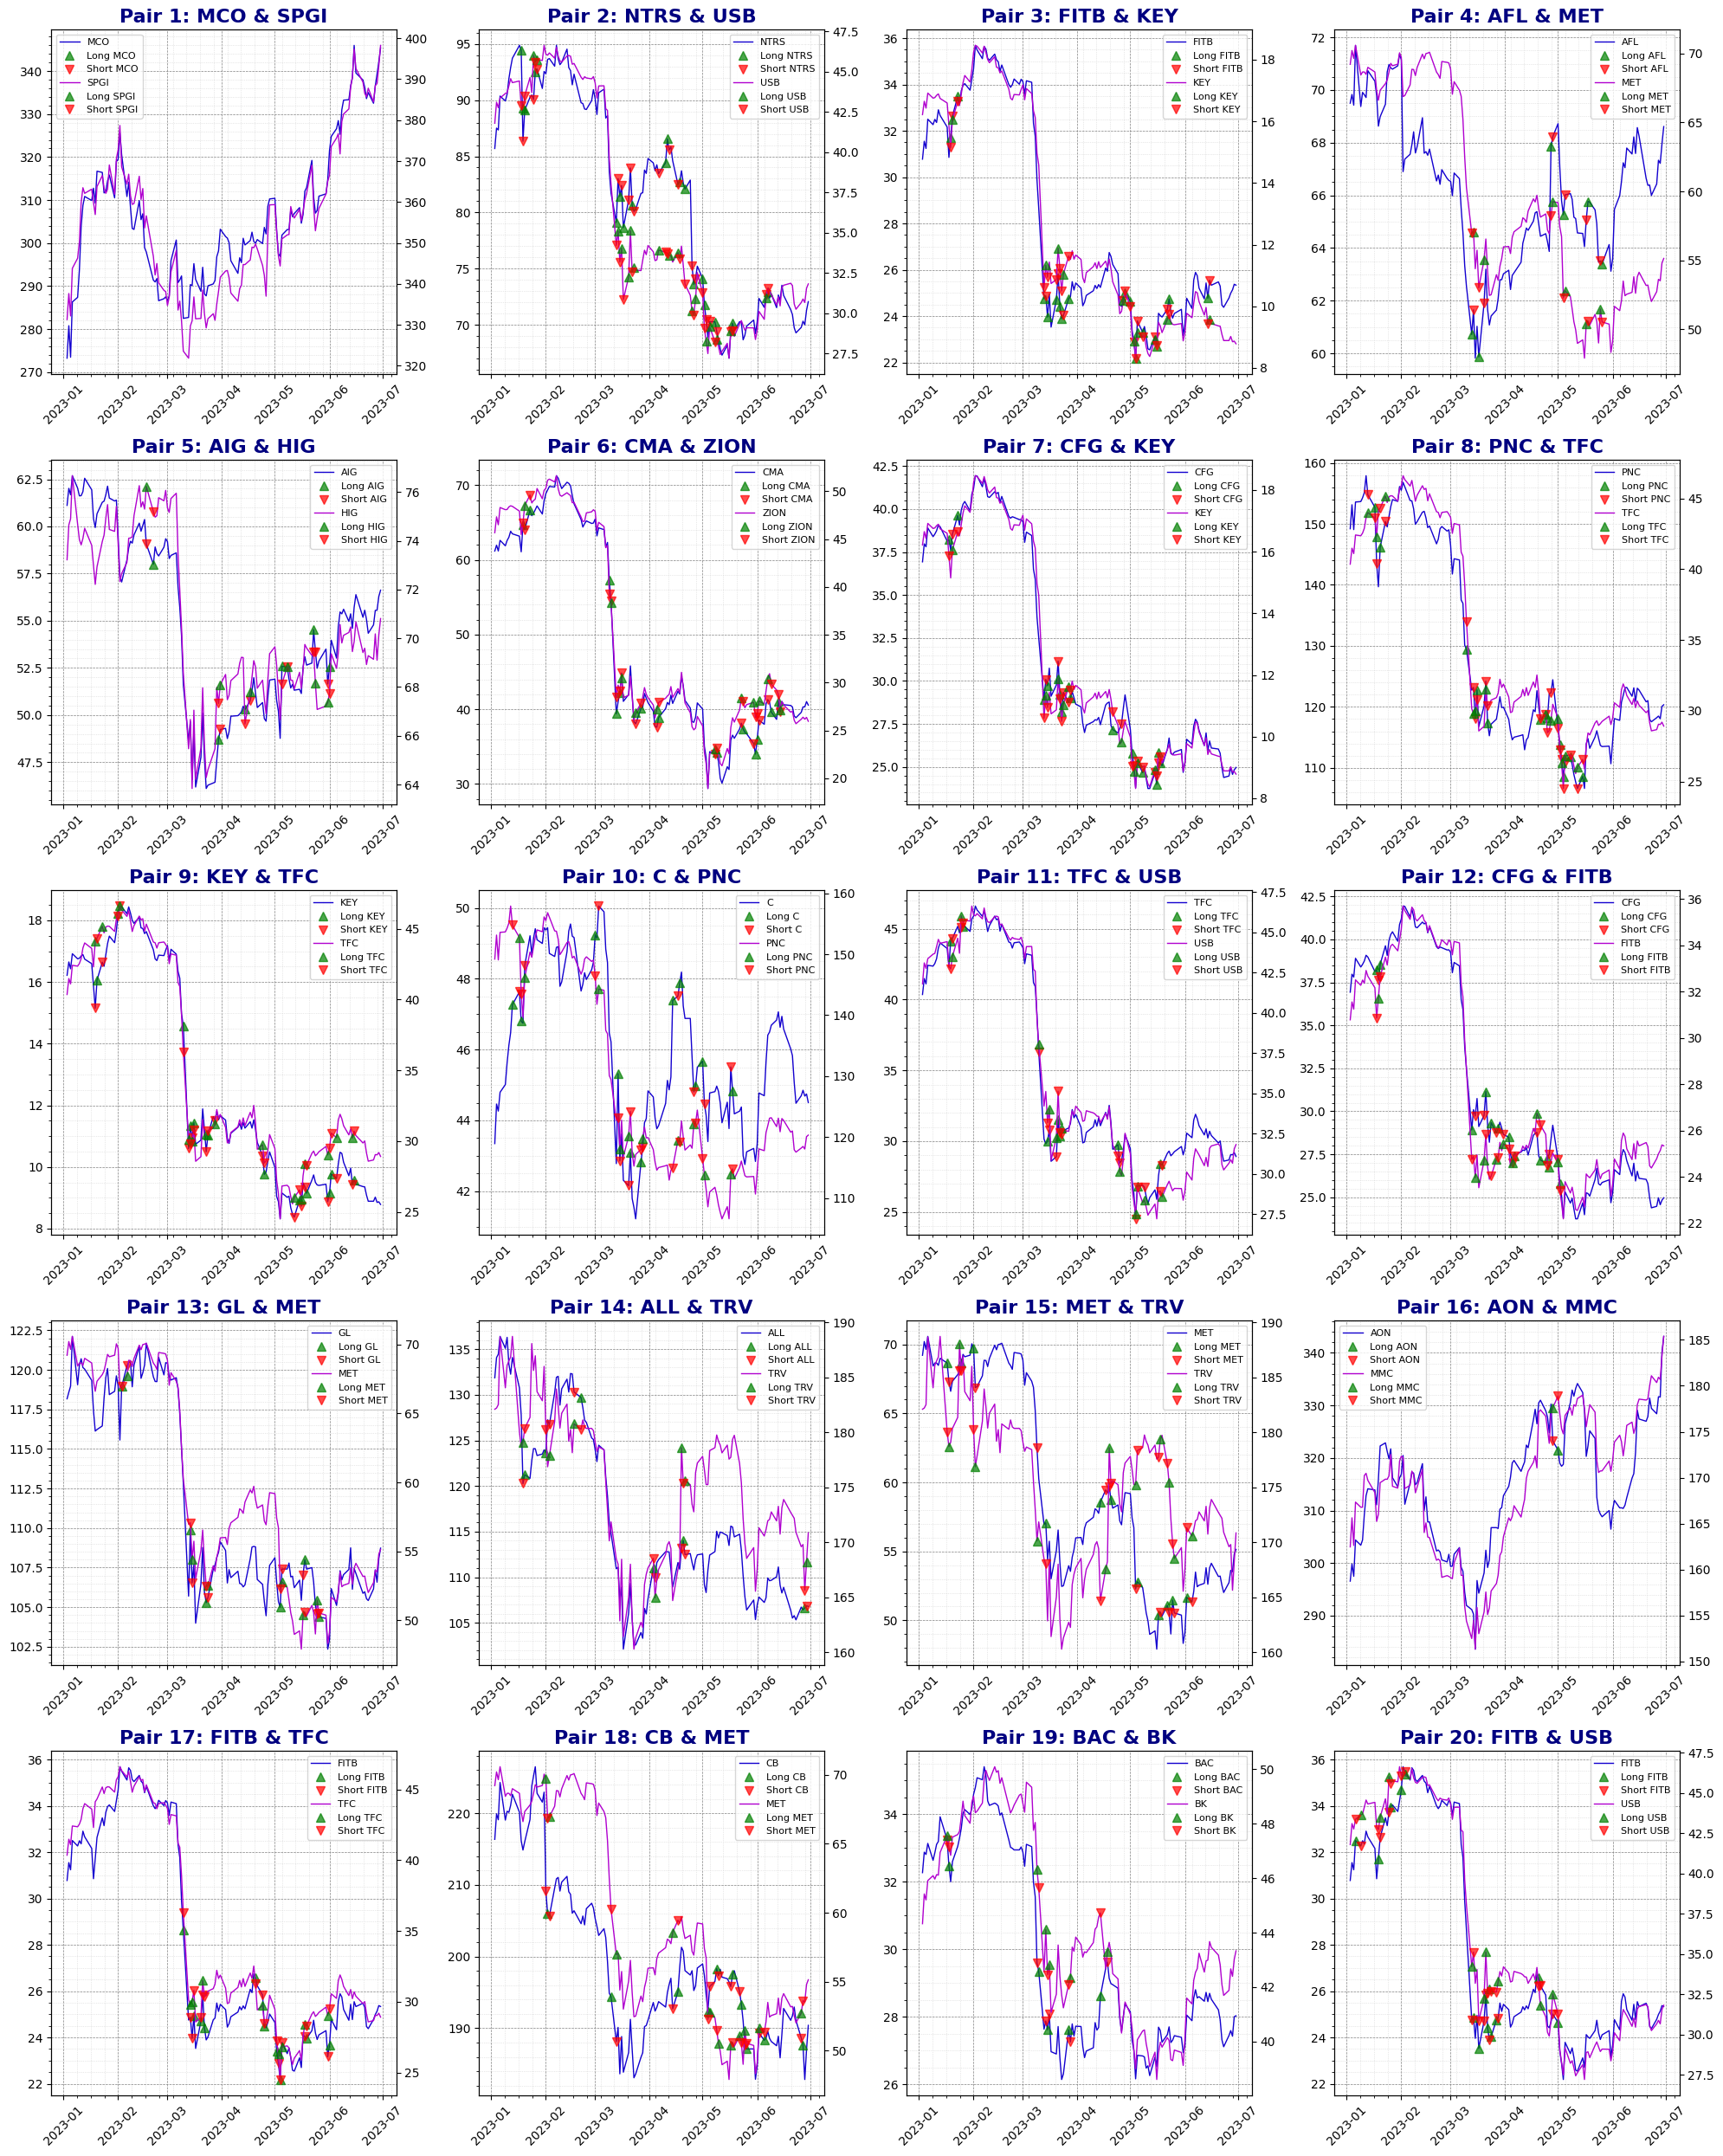

In [11]:
#plot_signals_pairs 

plot_signals_prices_pairs(test_data, signals, pairs)

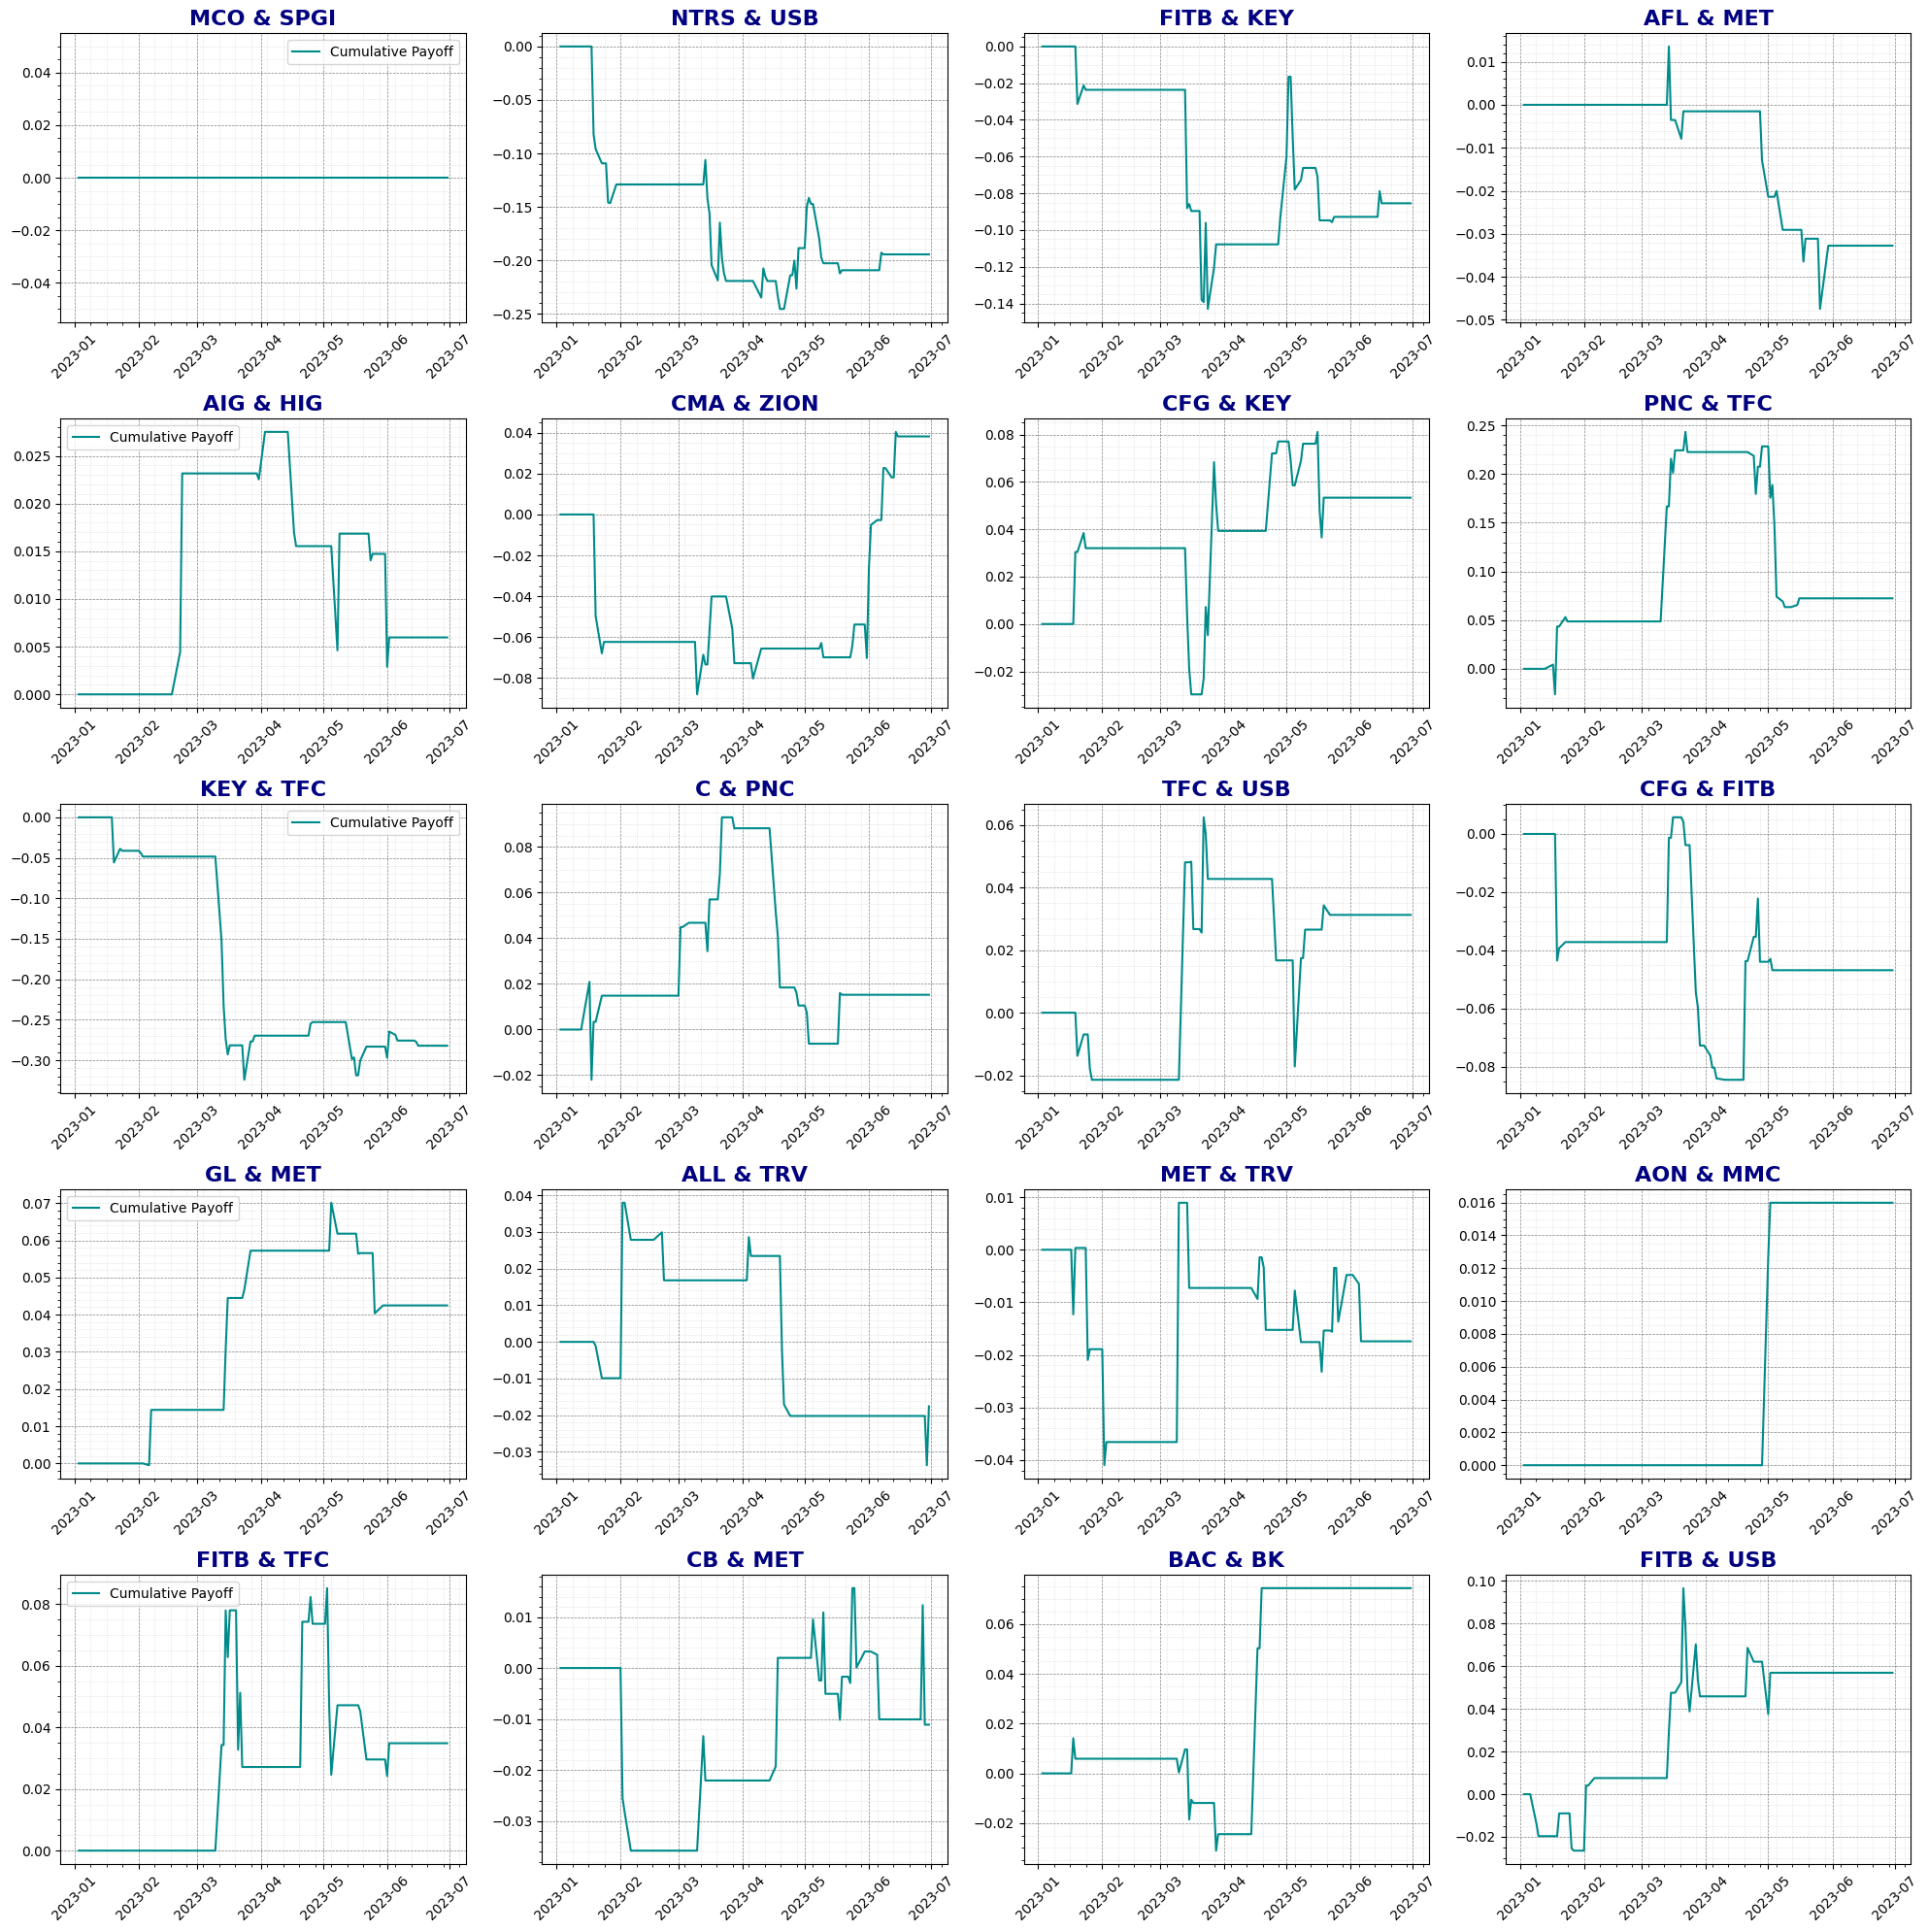

In [12]:
# Plot payoffs of each individual pair

plot_cumulative_payoff_idividual(test_data, signals, pairs)

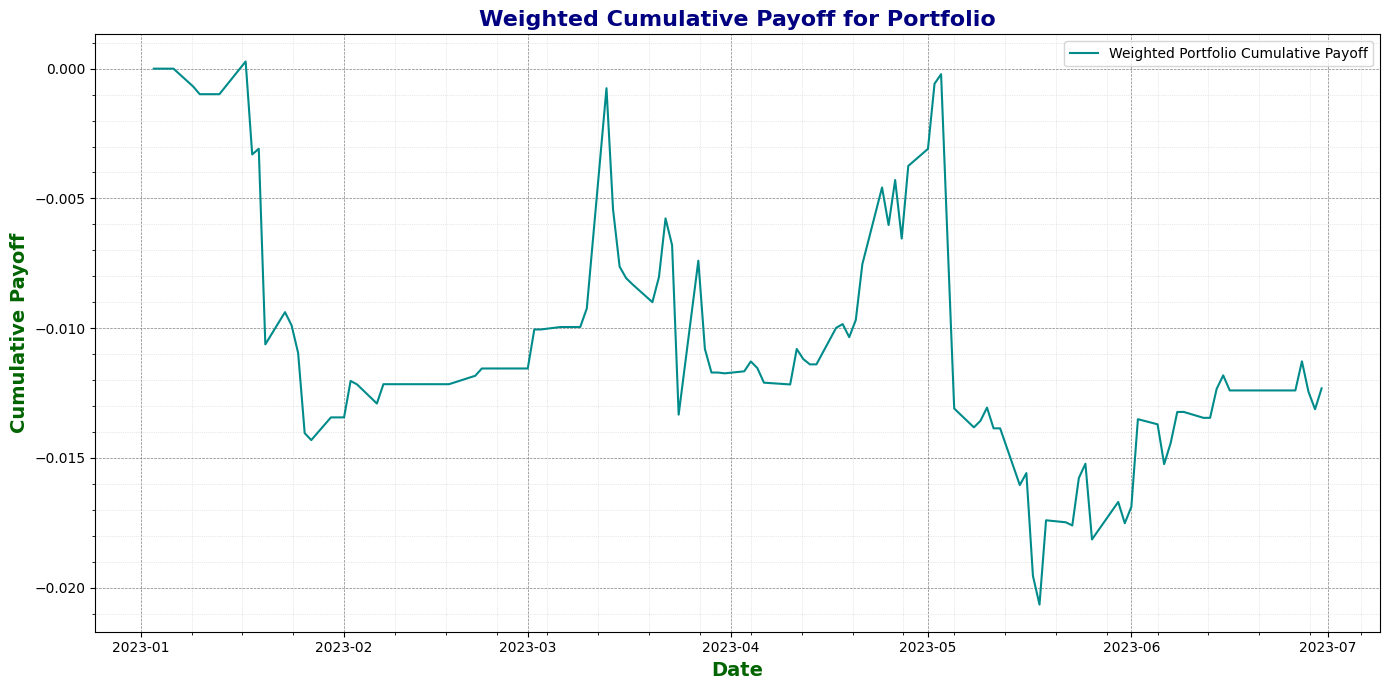

In [13]:
# Plot payoffs of portfolio with equal weights

weights = equal_weighing_scheme(pairs)
plot_cumulative_payoff_portfolio_weighted(test_data, signals, pairs, weights)